In [1]:
import os, sys
from pathlib import Path

# Notebook is inside: model/notebooks
CURRENT_DIR = Path.cwd()

# Go up two levels to project root
REPO_ROOT = CURRENT_DIR.parent.parent

BACKEND_DIR = REPO_ROOT / "backend"

print("Current dir:", CURRENT_DIR)
print("Repo root:", REPO_ROOT)
print("Backend dir:", BACKEND_DIR)

assert BACKEND_DIR.exists(), f"Can't find backend folder at: {BACKEND_DIR}"

# Make backend importable
sys.path.insert(0, str(BACKEND_DIR))
print("Backend path added successfully.")

Current dir: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\model\notebooks
Repo root: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc
Backend dir: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\backend
Backend path added successfully.


In [2]:
import numpy as np
import pandas as pd

from data_engine.yfinance_fetcher import YFinanceFetcher
from data_engine.forecasting.base_forecaster import SimpleForecaster

# LSTM may fail import if tensorflow isn't installed.
try:
    from data_engine.forecasting.lstm_model import LSTMForecastor
    LSTM_OK = True
except Exception as e:
    LSTM_OK = False
    print("LSTM import failed (likely missing TensorFlow). Error:\n", e)

In [3]:
import matplotlib.pyplot as plt

fetcher = YFinanceFetcher()

# Pick any symbol you want:
# Stocks: "AAPL", "MSFT"
# Crypto: "BTC-USD", "ETH-USD"
SYMBOL = "BTC-USD"
INTERVAL = "1wk"      # repo default
PERIOD = "5y"         # or "max"

df = fetcher.fetch_history(SYMBOL, interval=INTERVAL, period=PERIOD)

df.head(), df.columns

(                  timestamp          open          high           low  \
 0 2021-02-22 00:00:00+00:00  57532.738281  57533.390625  43241.617188   
 1 2021-03-01 00:00:00+00:00  45159.503906  52535.136719  45115.093750   
 2 2021-03-08 00:00:00+00:00  51174.117188  61683.863281  49506.054688   
 3 2021-03-15 00:00:00+00:00  59267.429688  60540.992188  53555.027344   
 4 2021-03-22 00:00:00+00:00  57517.890625  58471.480469  50856.570312   
 
           close        volume  dividends  stock_splits  
 0  45137.769531  766679775805        0.0           0.0  
 1  51206.691406  333113779409        0.0           0.0  
 2  59302.316406  373838576722        0.0           0.0  
 3  57523.421875  393542542227        0.0           0.0  
 4  55950.746094  403128836645        0.0           0.0  ,
 Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dividends',
        'stock_splits'],
       dtype='str'))

Rows: 261
Start: 2021-02-22 00:00:00+00:00 End: 2026-02-16 00:00:00+00:00


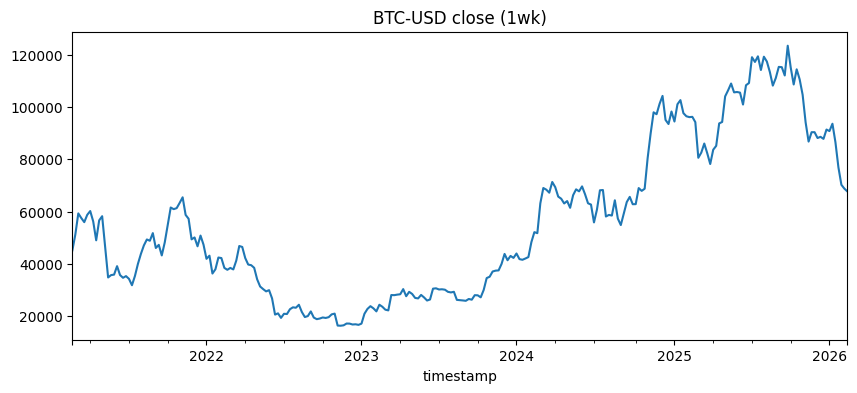

In [4]:
# Convert to the format your forecasting classes expect:
# pd.Series with DatetimeIndex, oldest -> newest, no NaNs

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

prices = (
    df.set_index("timestamp")["close"]
      .astype(float)
      .dropna()
)

print("Rows:", len(prices))
print("Start:", prices.index.min(), "End:", prices.index.max())

prices.plot(title=f"{SYMBOL} close ({INTERVAL})", figsize=(10,4))
plt.show()

In [5]:
# How many points to hold out for testing?
TEST_SIZE = 30  # e.g., last 30 weeks
assert len(prices) > TEST_SIZE + 60, "Not enough history for a decent test."

train_prices = prices.iloc[:-TEST_SIZE]
test_prices  = prices.iloc[-TEST_SIZE:]

train_prices.tail(), test_prices.head()

(timestamp
 2025-06-23 00:00:00+00:00    108385.570312
 2025-06-30 00:00:00+00:00    109232.070312
 2025-07-07 00:00:00+00:00    119116.117188
 2025-07-14 00:00:00+00:00    117300.789062
 2025-07-21 00:00:00+00:00    119448.492188
 Name: close, dtype: float64,
 timestamp
 2025-07-28 00:00:00+00:00    114217.671875
 2025-08-04 00:00:00+00:00    119306.757812
 2025-08-11 00:00:00+00:00    117453.062500
 2025-08-18 00:00:00+00:00    113458.429688
 2025-08-25 00:00:00+00:00    108236.710938
 Name: close, dtype: float64)

In [6]:
from math import sqrt

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    """
    Walk-forward 1-step backtest with expanding window.
    
    model_factory: callable that returns a NEW model instance each iteration
    min_train: minimum samples required before first forecast
    """
    preds = []
    
    split_idx = len(prices_full) - test_size
    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]
        
        if len(train) < min_train:
            continue
        
        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])
        
        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})
    
    out = pd.DataFrame(preds).set_index("timestamp")
    return out

def metrics(df_pred: pd.DataFrame):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

In [7]:
BASELINE_SPAN = 20

baseline_pred = backtest_one_step(
    prices_full=prices,
    test_size=TEST_SIZE,
    model_factory=lambda: SimpleForecaster(span=BASELINE_SPAN, confidence_level=0.95),
    min_train=BASELINE_SPAN
)

baseline_pred.head(), baseline_pred.tail()

(                                  y_true       y_pred
 timestamp                                            
 2025-07-28 00:00:00+00:00  114217.671875  103987.6245
 2025-08-04 00:00:00+00:00  119306.757812  104961.9147
 2025-08-11 00:00:00+00:00  117453.062500  106328.0902
 2025-08-18 00:00:00+00:00  113458.429688  107387.6114
 2025-08-25 00:00:00+00:00  108236.710938  107965.7846,
                                  y_true      y_pred
 timestamp                                          
 2026-01-19 00:00:00+00:00  86572.218750  97898.2107
 2026-01-26 00:00:00+00:00  76974.445312  96819.5448
 2026-02-02 00:00:00+00:00  70264.726562  94929.5353
 2026-02-09 00:00:00+00:00  68788.187500  92580.5059
 2026-02-16 00:00:00+00:00  67712.265625  90314.5708)

In [8]:
baseline_metrics = metrics(baseline_pred)
baseline_metrics

{'MAE': np.float64(11018.51624375),
 'RMSE': 13078.708783772932,
 'MAPE_%': np.float64(12.442344862465458)}

In [9]:
if not LSTM_OK:
    raise RuntimeError("LSTM not available. Install TensorFlow: pip install tensorflow")

LOOKBACK = 20
EPOCHS = 20      # start small; later try 50 as in repo default
BATCH = 16

lstm_pred = backtest_one_step(
    prices_full=prices,
    test_size=TEST_SIZE,
    model_factory=lambda: LSTMForecastor(
        lookback_window=LOOKBACK,
        epochs=EPOCHS,
        batch_size=BATCH,
        test_size=0.2,
        confidence_level=0.95,
        random_state=42,
    ),
    min_train=LOOKBACK + 1
)

lstm_pred.head(), lstm_pred.tail()

c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**

c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**

(                                  y_true       y_pred
 timestamp                                            
 2025-07-28 00:00:00+00:00  114217.671875  100434.7422
 2025-08-04 00:00:00+00:00  119306.757812  102247.3750
 2025-08-11 00:00:00+00:00  117453.062500  103360.3047
 2025-08-18 00:00:00+00:00  113458.429688  105650.9219
 2025-08-25 00:00:00+00:00  108236.710938  104514.8750,
                                  y_true      y_pred
 timestamp                                          
 2026-01-19 00:00:00+00:00  86572.218750  59407.2656
 2026-01-26 00:00:00+00:00  76974.445312  85200.0547
 2026-02-02 00:00:00+00:00  70264.726562  85534.9062
 2026-02-09 00:00:00+00:00  68788.187500  79421.4062
 2026-02-16 00:00:00+00:00  67712.265625  82960.8516)

In [10]:
lstm_metrics = metrics(lstm_pred)
lstm_metrics

{'MAE': np.float64(12432.327077916667),
 'RMSE': 14788.825865901259,
 'MAPE_%': np.float64(13.330004654713473)}

In [11]:
compare = pd.DataFrame([
    {"Model": "Baseline (EWM SimpleForecaster)", **baseline_metrics},
    {"Model": "LSTM (LSTMForecastor)", **lstm_metrics},
]).set_index("Model")

compare

,MAE,RMSE,MAPE_%
Model,,,
Baseline (EWM SimpleForecaster),11018.516244,13078.708784,12.442345
LSTM (LSTMForecastor),12432.327078,14788.825866,13.330005


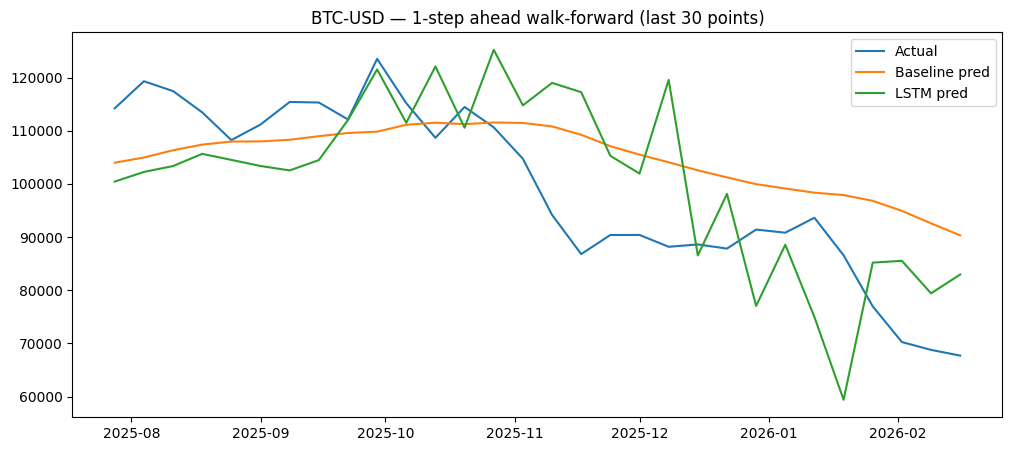

In [12]:
plot_df = baseline_pred.join(lstm_pred, lsuffix="_base", rsuffix="_lstm")

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["y_true_base"], label="Actual")
plt.plot(plot_df.index, plot_df["y_pred_base"], label="Baseline pred")
plt.plot(plot_df.index, plot_df["y_pred_lstm"], label="LSTM pred")
plt.title(f"{SYMBOL} — 1-step ahead walk-forward (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [13]:
from pathlib import Path

# Path setup
REPO_ROOT = Path.cwd().parent.parent
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

lstm_path = OUTDIR / "pred_lstm_weekly_price.parquet"

# Ensure timestamp is datetime (important for later joins)
lstm_to_save = lstm_pred.reset_index()
lstm_to_save["timestamp"] = pd.to_datetime(lstm_to_save["timestamp"])

lstm_to_save.to_parquet(lstm_path, index=False)

print("LSTM predictions saved to:", lstm_path)

LSTM predictions saved to: c:\Users\khanh\OneDrive - GUSCanada\Documents\capstone_project_unfc\model\notebooks\artifacts\pred_lstm_weekly_price.parquet
